In [1]:
addprocs(7)  # parallel computing

7-element Array{Any,1}:
 2
 3
 4
 5
 6
 7
 8

In [2]:
require("prepare_data_Sioux.jl");
require("extract_data_Sioux.jl");
require("tap_MSA_Sioux.jl");
require("../Julia_files/inverseVI.jl");
require("../Julia_files/demands_adjustment_gradi.jl");

    *(S<:Union(Variable,GenericQuadExpr{Float64,Variable},GenericAffExpr{Float64,Variable}),T<:GenericQuadExpr{Float64,Variable}) at /home/jzh/.julia/v0.3/JuMP/src/operators.jl:611
is ambiguous with: 
    *(T<:GenericQuadExpr{Float64,Variable},S<:Union(Variable,GenericQuadExpr{Float64,Variable},GenericAffExpr{Float64,Variable})) at /home/jzh/.julia/v0.3/JuMP/src/operators.jl:607.
To fix, define 
    *(T<:GenericQuadExpr{Float64,Variable},T<:GenericQuadExpr{Float64,Variable})
before the new definition.


In [3]:
require("initia_data.jl");

In [4]:
demandsDiffDict[1] = norm(demandsDicToVec(demandsDict[1]) - demandsDicToVec(demandsDict[0]))/
norm(demandsDicToVec(demandsDict[0]));

In [5]:
fcoeffs = [1, 0, 0, 0, .15];

# get observed flow vector (corresponding to ground truth demands and ground truth costs)
tapFlowDicDict[0], tapFlowVecDict[0] = tapMSA(demandsDict[0], fcoeffs);

In [6]:
# get arcs data corresponding to ground truth demands and flows
arcsDict[0] = observFlow("../data_original/SiouxFalls_net.txt", tapFlowDicDict[0]);

In [7]:
deg = 6
c = 3.41
lam = 1.

coeffs_dict[(deg, c, lam, 1)], objInvVIDict[1] = train(lam, deg, c, demandsDict[1], arcsDict[0]);

In [8]:
# get initial flow vector (corresponding to initial demands)
tapFlowDicDict[1], tapFlowVecDict[1] = tapMSA(demandsDict[1], coeffs_dict[(deg, c, lam, 1)]);

demandsVecDict[0] = demandsDicToVec(demandsDict[0]);

In [9]:
# get arcs data corresponding to initial demands and flows
arcsDict[1] = observFlow("../data_original/SiouxFalls_net.txt", tapFlowDicDict[1]);

In [10]:
linkCostDicDict[1] = tapFlowVecToLinkCostDict(tapFlowVecDict[1], coeffs_dict[(deg, c, lam, 1)]);

In [11]:
tau = 0.5;

In [12]:
jacobiSpiessDict[1] = jacobianSpiess(numLinks, numODpairs, numRoutes, linkRoute, odPairRoute);

In [13]:
# number of iterations
N = 29;  

In [14]:
for iterNumber = 1:N
    
    l = iterNumber;
    
#     jacobDict[l] = jacobian(tapFlowVecDict[l], coeffs_dict[(deg, c, lam, l)], capacity, 
#     free_flow_time, numLinks, numODpairs, numRoutes, linkRoute, odPairRoute);
    
    jacobDict[l] = jacobiSpiessDict[l]

    descDirecDict[l] = descDirec(tapFlowVecDict[l], tapFlowVecDict[0], jacobDict[l], numODpairs, numLinks);

    demandsVecDict[l] = demandsDicToVec(demandsDict[l]);

    searchDirecDict[l] = searchDirec(demandsVecDict[l], descDirecDict[l], 0);

    thetaMaxDict[l] = thetaMax(demandsVecDict[l], searchDirecDict[l]);

    objFunDict[l] = objF(demandsVecDict[l]);

    demandsVecDict[l+1] = similar(demandsVecDict[0]);
    
    demandsVecDict[l+1], objFunDict[l+1] = armijo(demandsVecDict[l], searchDirecDict[l], thetaMaxDict[l], 10, 3);
            
    demandsDict[l+1] = demandsVecToDic(demandsVecDict[l+1]);
    
    tapFlowDicDict[l+1], tapFlowVecDict[l+1] = tapMSA(demandsDict[l+1], coeffs_dict[(deg, c, lam, l)]);
        
    arcsDict[l+1] = observFlow("../data_original/SiouxFalls_net.txt", tapFlowDicDict[l+1]);
        
    coeffs_dict[(deg, c, lam, l+1)], objInvVIDict[l+1] = train(lam, deg, c, demandsDict[l+1], arcsDict[l+1]);
    
    linkCostDicDict[l+1] = tapFlowVecToLinkCostDict(tapFlowVecDict[l+1], coeffs_dict[(deg, c, lam, l+1)]);
    
    odPairRouteDict[l+1] = odPairRouteProb(tau, lengthRouteVec(linkCostDicDict[l+1]), OD_pair_route_dict, numODpairs, 
    numRoutes);
    
    jacobiSpiessDict[l+1] = jacobianSpiess(numLinks, numODpairs, numRoutes, linkRoute, odPairRouteDict[l+1]);
        
    demandsDiffDict[l+1] = norm(demandsVecDict[l+1] - demandsVecDict[0]) / norm(demandsVecDict[0]);
        
end

# normalize objective function value
for l = 1:(N+1)
    norObjFunDict[l] = objFunDict[l] / objFunDict[1];
end

In [15]:
demandsVecDict

Dict{Int64,Array{Float64,1}} with 31 entries:
  18 => [129.32362135555235,118.12229802547974,558.9262902803177,219.61055024605…
  30 => [129.33858291820803,118.12770963931614,558.9385140678378,219.63572550736…
  2  => [128.95125124983107,117.9660890510237,558.5968303464509,218.962036040461…
  16 => [129.32362135555235,118.12229802547974,558.9262902803177,219.61055024605…
  11 => [129.05830213618458,118.00723861188777,558.6933410365791,219.15128080819…
  21 => [129.33858291820803,118.12770963931614,558.9385140678378,219.63572550736…
  0  => [100.0,100.0,500.0,200.0,300.0,500.0,800.0,500.0,1300.0,500.0,200.0,500.…
  7  => [128.95146261377502,117.96618984674286,558.5970407797937,218.96244071342…
  9  => [128.9515699571619,117.9662354915807,558.5971387459592,218.9626369020803…
  10 => [129.05830213618458,118.00723861188777,558.6933410365791,219.15128080819…
  25 => [129.33858291820803,118.12770963931614,558.9385140678378,219.63572550736…
  26 => [129.33858291820803,118.12770963931614,558.9

In [16]:
norObjFunDict

Dict{Int64,Float64} with 30 entries:
  18 => 0.9354305919439246
  30 => 0.9340342503036414
  2  => 0.9420531670434823
  16 => 0.9354305919439246
  11 => 0.9387587116170146
  21 => 0.9340342503036414
  7  => 0.9420510436235564
  9  => 0.94204998282332
  25 => 0.9340342503036414
  10 => 0.9387587116170146
  26 => 0.9340342503036414
  29 => 0.9340342503036414
  19 => 0.9340352679267272
  17 => 0.9354305919439246
  8  => 0.94204998282332
  22 => 0.9340342503036414
  6  => 0.9420510436235564
  24 => 0.9340342503036414
  4  => 0.9420510436235564
  3  => 0.9420521075526679
  28 => 0.9340342503036414
  5  => 0.9420510436235564
  20 => 0.9340342503036414
  23 => 0.9340342503036414
  13 => 0.9366317965432884
  ⋮   => ⋮

INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...


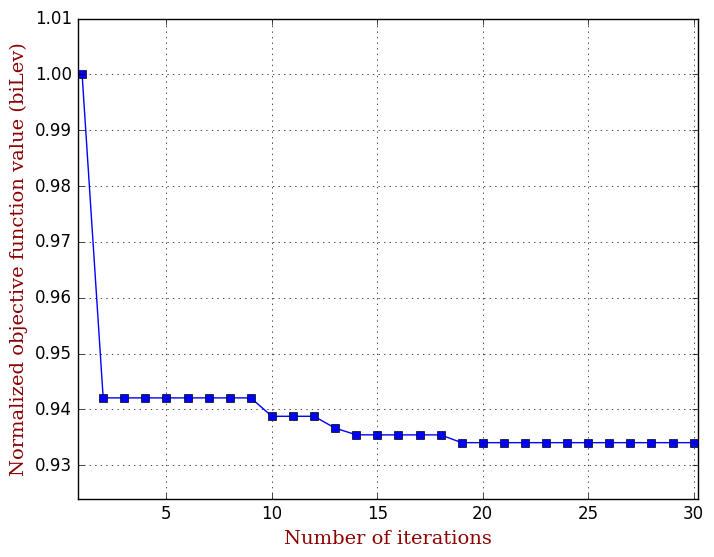

In [17]:
using PyPlot

iterNum = 1:(N+1)

objFun = map(iterNum->norObjFunDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "s-b")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, N + 1 + .2)
ylim(minimum(objFun)-.01, maximum(objFun)+.01)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized objective function value (biLev)", fontdict=font1)

savefig("./results/objFun_biLev_Sioux.pdf")

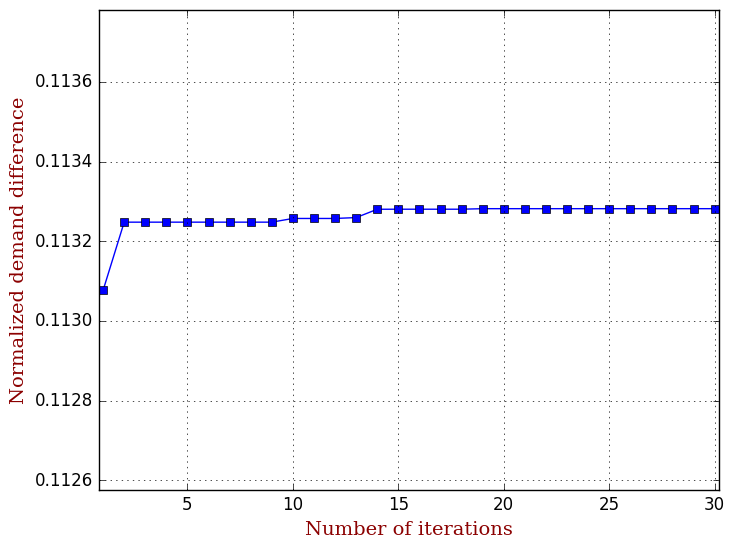

In [18]:
using PyPlot

iterNum = 1:(N+1)

demandsDiff = map(iterNum->demandsDiffDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, demandsDiff, "s-b")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(.8, N + 1 + .2)
ylim(minimum(demandsDiff)-.0005, maximum(demandsDiff)+.0005)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Normalized demand difference", fontdict=font1)

savefig("./results/demandsDiff_biLev_Sioux.pdf")

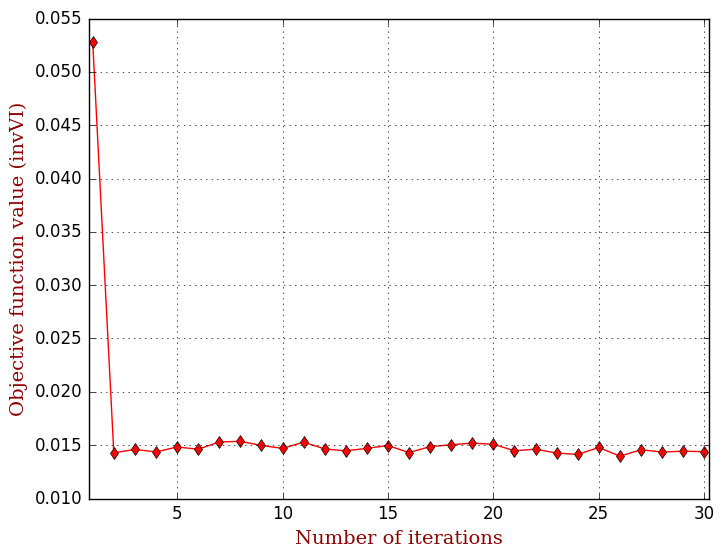

In [19]:
using PyPlot

iterNum = 1:(N+1)

objFun = map(iterNum->objInvVIDict[iterNum], iterNum)

# plot(iterNum, objFun, "s-g", label="True")

plot(iterNum, objFun, "d-r")

# legend(loc="upper right",fancybox="true") 

grid("on")

xlim(0.8, N + 1 + .2)
# ylim(0.9, 2.0)

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]

xlabel("Number of iterations", fontdict=font1)
ylabel("Objective function value (invVI)", fontdict=font1)

savefig("./results/objFun_invVI_Sioux.pdf")

In [20]:
coeffs_dict

Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}} with 30 entries:
  (6,3.41,1.0,6)  => [1.0,0.044710119105771114,-0.16793867432545026,0.1684314587…
  (6,3.41,1.0,11) => [1.0,0.03933812796722305,-0.15008423915369457,0.14921946292…
  (6,3.41,1.0,20) => [1.0,0.04281831895537001,-0.1475200223031492,0.121329511962…
  (6,3.41,1.0,21) => [1.0,0.03719431320939595,-0.13265777060176517,0.11162531367…
  (6,3.41,1.0,25) => [1.0,0.019218334851366883,-0.07728174402888989,0.0569953456…
  (6,3.41,1.0,13) => [1.0,0.046266573641104404,-0.16697674422823763,0.1600528424…
  (6,3.41,1.0,30) => [1.0,0.03455054939964341,-0.12550951414702516,0.10496288380…
  (6,3.41,1.0,3)  => [1.0,0.03299617842277576,-0.13729758529485273,0.14728167646…
  (6,3.41,1.0,10) => [1.0,0.038220664255751775,-0.15239136008336782,0.1631584502…
  (6,3.41,1.0,8)  => [1.0,0.04513170038839243,-0.16969203681147088,0.17391379809…
  (6,3.41,1.0,15) => [1.0,0.04723971420723461,-0.16249162665573144,0.13961989332…
  (6,3.41,1.0,29) => [1.0,0.

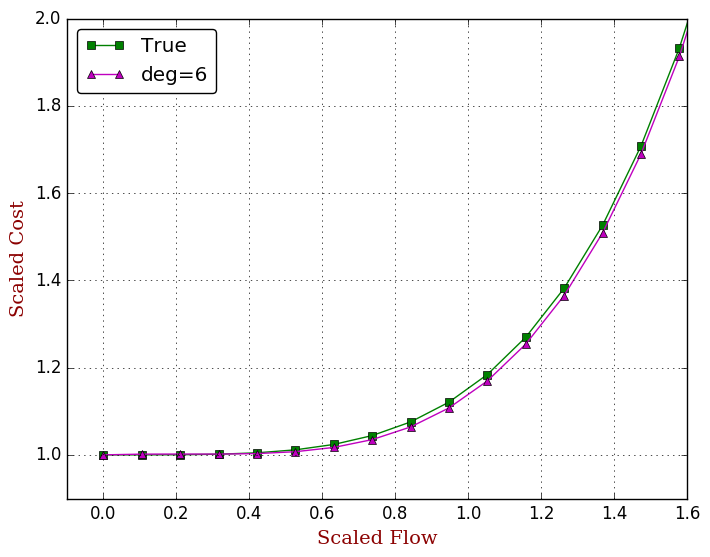

In [21]:
using PyPlot

iterN = 1

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")

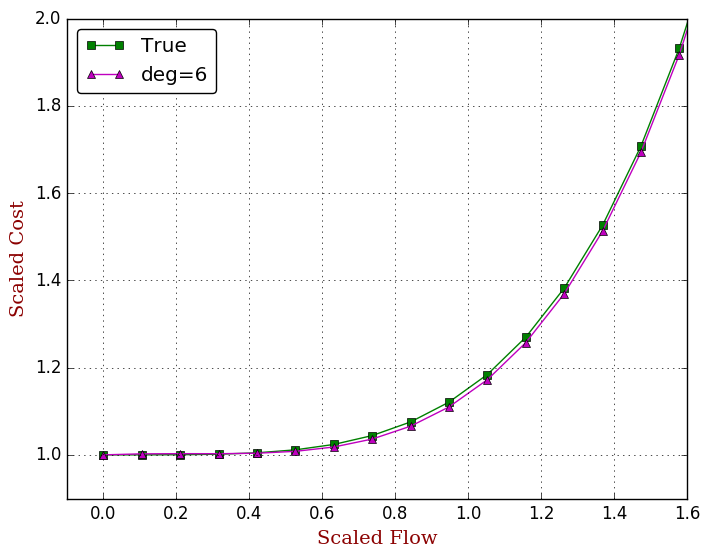

In [22]:
using PyPlot

iterN = 2

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")

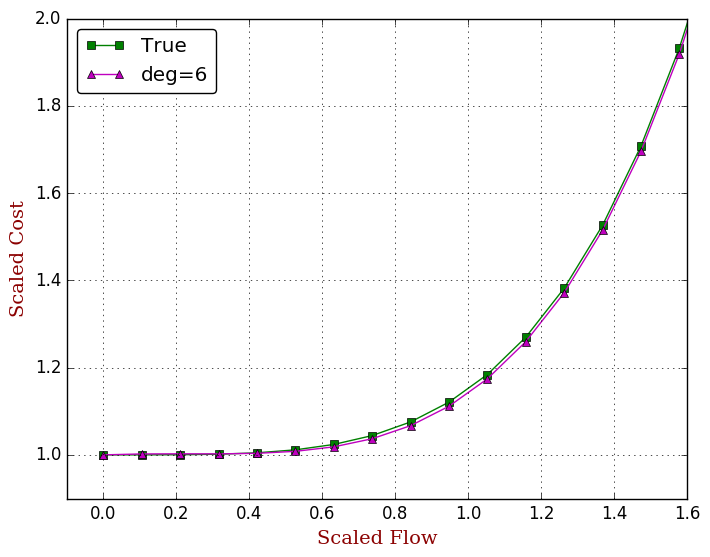

In [23]:
using PyPlot

iterN = 3

true_coeffs = [1, 0, 0, 0, .15]
# true_coeffs = [1, .2, .5, .8, .15]

est_coeffs = coeffs_dict[(6, 3.41, 1., iterN)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(est_coeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif","color"=>"darkred","weight"=>"normal","size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_iter_$(iterN).pdf")